In [ ]:
# BRAN2020 model data is used to access Ocean Current data (U and V currents)
# The full data catalogue is available at: https://dapds00.nci.org.au/thredds/catalog/gb6/BRAN/BRAN2020/catalog.html 
# References used for this notebook: 
# 1) https://gist.github.com/mrayson/28cc2fa25eb3ea59b2885e651c587dd2
# 2) https://tristansalles.github.io/EnviReef/6-addson/parcels.html
# 3) https://oceanparcels.org/#tutorials

In [ ]:
# Import libraries
import os
import numpy as np
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset, num2date
import datetime as dt

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta
from operator import attrgetter

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Comment out the below if needed
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

 97%|█████████▋| 2502000.0/2592000.0 [00:19<00:00, 12518118.26it/s]

In [ ]:
# STEP ONE: Open BRAN2020 netCDF files and crop to make data managable (reduce data size)

In [ ]:
# Open a select month of U and V Current files ('U': 'eastward_eulerian_current_velocity', 'V': 'northward_eulerian_current_velocity')

month = 1   # Month
year = 2022    # Year

netCDF_datestr = str(year)+'_'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

u_files = "https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_u_"+netCDF_datestr+".nc"
v_files = "https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_v_"+netCDF_datestr+".nc"

In [ ]:
#Lat/Lon crop

min_lon = 148.
min_lat = -48.
max_lat = -17.
max_lon = 160.

In [ ]:
#Creating a cropped file for U Current
ds_u = xr.open_dataset(u_file, chunks='auto', 
                                 drop_variables=['Time_bounds', 'average_DT', 'average_T1' , 
                                                 'average_T2', 'st_edges_ocean', 'nv'])
mask_lon = (ds_u.xu_ocean >= min_lon) & (ds_u.xu_ocean <= max_lon)
mask_lat = (ds_u.yu_ocean >= min_lat) & (ds_u.yu_ocean <= max_lat)
cropped_ds_u = ds_u.where(mask_lon & mask_lat, drop=True)
photicZone = cropped_ds_u.isel(st_ocean= slice(0,3))
    
photicZone.to_netcdf('photicZone_Current_u'+str(month)+'_'+str(year)+'.nc')

In [ ]:
#Creating a cropped file for V Current
ds_v = xr.open_dataset(v_file, chunks='auto', 
                                 drop_variables=['Time_bounds', 'average_DT', 'average_T1' , 
                                                 'average_T2', 'st_edges_ocean', 'nv'])
mask_lon = (ds_v.xu_ocean >= min_lon) & (ds_v.xu_ocean <= max_lon)
mask_lat = (ds_v.yu_ocean >= min_lat) & (ds_v.yu_ocean <= max_lat)
cropped_ds_v = ds_v.where(mask_lon & mask_lat, drop=True)
photicZone = cropped_ds_v.isel(st_ocean= slice(0,3))
    
photicZone.to_netcdf('photicZone_Current_v'+str(month)+'_'+str(year)+'.nc')

In [ ]:
# STEP TWO: Combine U and V current files and calculate the velocity (speed)

In [ ]:
# Open a select month and year of the cropped U and V current files

month = 1   # Month
year = 2022 # Year

ds_u = 'photicZone_Current_u'+str(month)+'_'+str(year)+'.nc'
ds_v = 'photicZone_Current_v'+str(month)+'_'+str(year)+'.nc'

In [ ]:
# Subset an xarray.DataArray

my_u = ds_u['u'].sel(st_ocean=7.5)
my_v = ds_v['v'].sel(st_ocean=7.5)

In [ ]:
# Calculate the current velocity as 'speed'

speed = np.abs(my_u + 1j*my_v)

In [ ]:
%%time
# (this will actually download the data)
speed = speed.compute()

In [ ]:
out_ds = xr.DataArray({'u':my_u,'v':my_v, 'speed':speed})

In [ ]:
out_ds = xr.Dataset({'u':my_u,'v':my_v, 'speed':speed})

In [ ]:
# Save as a new combined netCDF file, containing U and V current and speed

out_ds.to_netcdf('Current_speed_UandV_'+str(month)+'_'+''+str(year)+'.nc')

In [ ]:
# STEP THREE: Run the Ocean Parcels particle simulation

In [2]:
# Open a select month and year of the combined U and V current and speed netCDF

month = 11  # Month
year = 2021    # Year

netCDF_datestr = str(year)+'_'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

data_name = "Current_speed_UandV_"+netCDF_datestr+".nc"


File chosen time interval: 2021_11


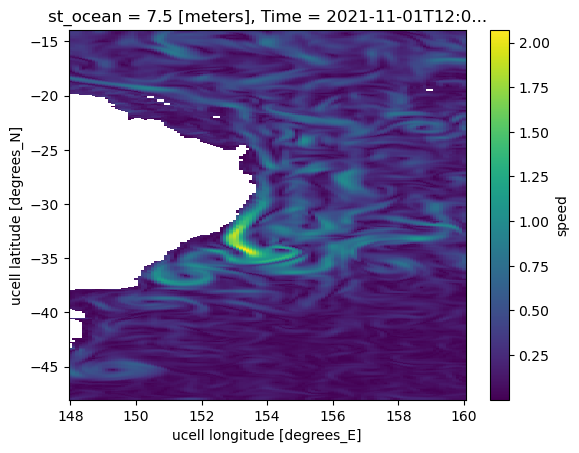

In [3]:
# Check visual for data completeness

ds = xr.open_dataset(data_name)
ds.isel(Time=0).speed.plot()

In [4]:
# Create a data file structure for data_name 

filenames = {'U': data_name,
             'V': data_name,
            }

variables = {'U': 'u',
             'V': 'v'}

dimensions = {'lat': 'yu_ocean',
              'lon': 'xu_ocean',
              'time': 'Time'}

In [5]:
# From parcels import FieldSet 
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [7]:
# This is a function to remove particles that go 'out of bounds' from the defined lat/lon range.

def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [8]:
class DistParticle(JITParticle):  # Define a new particle class that contains three extra variables
    
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.

In [9]:
def TotalDistance(particle, fieldset, time):
    
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

In [10]:
# Simulating particle release from pre-defined locations and depth

pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=DistParticle,
                             #Location points chosed near Capricorn group, Julian Rocks, Bryon Bay.
                             lon=[148., 150., 153., 153., 151., 153., 155., 155., 156., 158.],
                             lat=[-21.,-21., -21., -24., -23., -30.5,-21., -30.5, -21., -21.],
                             depth=[7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5])

In [11]:
print(pset)

P[0](lon=148.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[1](lon=150.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[2](lon=153.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[3](lon=153.000000, lat=-24.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[4](lon=151.000000, lat=-23.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[5](lon=153.000000, lat=-30.500000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[6](lon=155.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[7](lon=155.000000, lat=-30.500000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[8](lon=156.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=not_yet_set)
P[9](lon=158.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=not_yet_set)


In [12]:
output_nc_dist = 'CurrentParticlesDist_'+str(year)+'_'+format(month, '02')+'.nc'
try:
    os.remove(output_nc_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_nc_dist, 
                                outputdt=timedelta(hours=1))

k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.

pset.execute(AdvectionRK4 + k_dist,  # Add kernels using the + operator.
             runtime=timedelta(days=30),
             dt=timedelta(minutes=5),
             output_file=file_dist,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

file_dist.export()

INFO: Compiled ArrayDistParticleAdvectionRK4TotalDistance ==> /tmp/parcels-178411/lib7a2906b7cdfa440d6e92acd9dd96cb04_0.so
INFO: Temporary output files are stored in out-FENHVDJJ.
INFO: You can use "parcels_convert_npydir_to_netcdf out-FENHVDJJ" to convert these to a NetCDF file during the run.
 55%|█████▍    | 1414800.0/2592000.0 [00:00<00:00, 12518118.26it/s]

TimeExtrapolationError: U sampled outside time domain at time 2021-11-30T12:00:00.000000000.In fset.computeTimeChunk Try setting allow_time_extrapolation to True

In [ ]:
#We can now print the distance in km that each particle has travelled:

print([p.distance for p in pset])

In [ ]:
parcels_dist = xr.open_dataset(output_nc_dist)
parcels_dist

In [ ]:
# Rename U and V and speed data for use in final plot
ds_hydro = xr.open_dataset(data_name)
ds_hydro

In [ ]:
# Import the custom marker package
import matplotlib as mpl
!pip install svgpath2mpl
!pip install svgpathtools

In [ ]:
# Creating a custom 'fish' maker
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

fish_path, attributes = svg2paths('solidfish.svg')
fish_marker = parse_path(attributes[0]['d'])

In [ ]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())


# Plotting mean current 
cf = ds_hydro.speed.mean('Time').plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0.1, vmax = 1.0, alpha=0.2, 
    add_colorbar=False
)

# Color bar
# cbar = fig.colorbar(cf, ax=ax, orientation="horizontal",shrink=0.5) #fraction=0.027, pad=0.045, )

# Title
plt.title('Parcels evolution coloured by distance travelled '+str(year)+'_'+str(month),
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# # Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

distmin = parcels_dist.distance.min().item()
distmax = parcels_dist.distance.max().item()

fish_marker.vertices -= fish_marker.vertices.mean(axis=0)
fish_marker = fish_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
fish_marker = fish_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))

for k in range(parcels_dist.lon.shape[0]):
    sc = plt.scatter(parcels_dist.lon.isel(traj=k), parcels_dist.lat.isel(traj=k), marker = fish_marker, s=45, 
               c=parcels_dist.distance.isel(traj=k), edgecolors='w', 
               cmap='cmo.curl_r', vmin=distmin, vmax=distmax, 
               linewidth=0.1, transform=ccrs.PlateCarree()).set_zorder(11)
    

# # Color bar

# Adding the colorbar
cbaxes2 = fig.add_axes([0.7, 0.2, 0.02, 0.7]) 
cbar2 = plt.colorbar(sc, cax=cbaxes2) #, fraction=0.027, pad=0.045)
cbar2.set_label('Distance travelled in km', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

cbaxes = fig.add_axes([0.3, -0.035, 0.4, 0.02]) 
cbar = fig.colorbar(cf, cax=cbaxes, orientation="horizontal") #ax=ax, fraction=0.027, pad=0.045, 
#                     orientation="horizontal")

cbar.set_label('Northward and eastward eularian current velocity (m/s)', rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Sydney dot
syd_lat = -33.8
syd_lon = 151
ax.scatter(syd_lon, syd_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
           transform=ccrs.PlateCarree())
ax.plot(syd_lon, syd_lat, transform=ccrs.Geodetic())
ax.text(syd_lon-2, syd_lat, 'Sydney', transform=ccrs.Geodetic())


#Newcastle plot
newc_lat = -32.92
newc_lon = 151.70
ax.scatter(newc_lon, newc_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(newc_lon, newc_lat, transform=ccrs.Geodetic())
ax.text(newc_lon-2.5, newc_lat, 'Newcastle', transform=ccrs.Geodetic())

#Byron Bay Plot
bbay_lat = -28.64
bbay_lon = 153.50
ax.scatter(bbay_lon, bbay_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-2.5, bbay_lat, 'Byron Bay', transform=ccrs.Geodetic())


plt.tight_layout()
#plt.savefig('Particle'+str(year)+'_'+str(month)+'.png',dpi=300)
plt.show()
fig.clear()
plt.close(fig)
plt.clf()


In [ ]:
# The end.